___
### <center> <u> <h1> <strong> Diagramme Temp - Fréquence </strong> </h1> </center>

<h3>
Dans ce notebook on verra en détails :
    
<strong> 

- L'utilisation de la transformée de Fourier en Python

- La transformée de Gabor en Python
    
- L'utilisation de la transformée de Gabor pour obtenir la photographie de la transformée de Fourier à chaque instant du temps ( spectograme )


</strong>
</h3>
    
---

<h1> <strong> 1 - Importation des modules necessaires

In [1]:
################################################################################
##################  Bibliothèque utilitaire mathémlatiques  ####################
################################################################################
import numpy as np
import pandas as pd

################################################################################
##################         Bibliothèque graphique           ####################
################################################################################
import matplotlib.pyplot as plt

################################################################################
################  Bibliothèque utilitaire de fichiers audios  ##################
################################################################################
try : 
    import librosa
except :
    !pip install --upgrade pip
    !pip install librosa
    import librosa

################################################################################
##################    Bibliothèque de gestion du système    ####################
################################################################################
import os

################################################################################
######  Bibliothèque pour l'écoute de fichiers audio dans notre cas   ##########
################################################################################
import IPython.display as ipd

try :
    from tqdm import tqdm
except :
    ! pip install tqdm
    from tqdm import tqdm


<h3>
    <p> Ce notebook fait suite au <a href="https://github.com/Brice-KENGNI-ZANGUIM/Signal_Processing/blob/main/2%20-%20Transform%C3%A9e%20de%20Fourier%20et%20le%20son-%20Cas%20pratique/Transform%C3%A9e%20de%20Fourier%20dans%20la%20musique.ipynb" target="_blank"> notebook précédant sur la transformée de Fourier </a> dans lequel on a décomposé un signal temporel donné en ses différentes composantes spectrales.</p>
    <p> La transformée de Fourier permet en effet d'avoir une photographie spectrale de toutes les frequences qui compose un signal sur toute sa durée. Il est possible d'obtenir une photographie 'à chaque instant' de temps en réalisant une convolution du signal en utilisant un masque caractéristique </p>
    <p> Le cas particulier où un masque gaussien est utilisé est dénomé Transformation de Gabor. Considérons le signal ci-dessous : </p>
</h3>

In [2]:
durée = 3
N_echantillon = 1000
sample_rate = N_echantillon/durée
mu = 5
t = np.linspace(0 , durée , N_echantillon)

signal = 2*np.cos(2*np.pi*mu*t)*np.exp(-5*t/mu) 

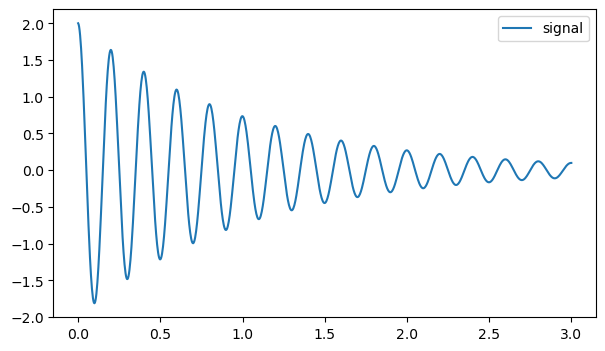

In [3]:
plt.figure(figsize = (7,4))

plt.plot(t, signal, label="signal")

plt.legend()
plt.show()

<h2> Et le masque carré suivant centré sur la seconde 1

In [4]:
def porte( centre , ouverture ) :

    return ( t > centre -ouverture/2) * (t < centre + ouverture/2)


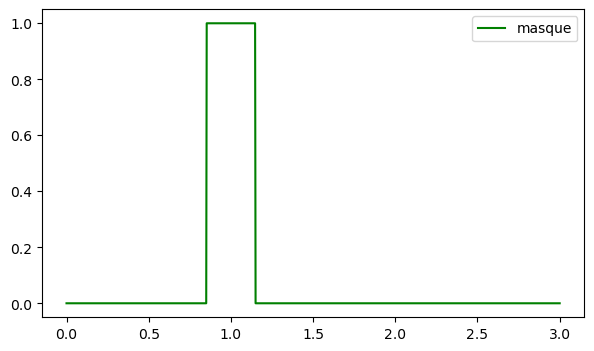

In [5]:
porte_0 = porte( 1 , durée/10)
    
plt.figure(figsize = (7,4))

plt.plot(t, porte_0, label="masque", color ="green")

plt.legend()
plt.show()

<h2> Si l'on souhaite observer le signal présécent au travers du masque ci-dessus, un peu comme si on souhaite voire le contenu d'une maison ( ici le signal ) à travers sa porte ( ici le masque ); il suffirait de réaliser un produit mathématique des deux entités

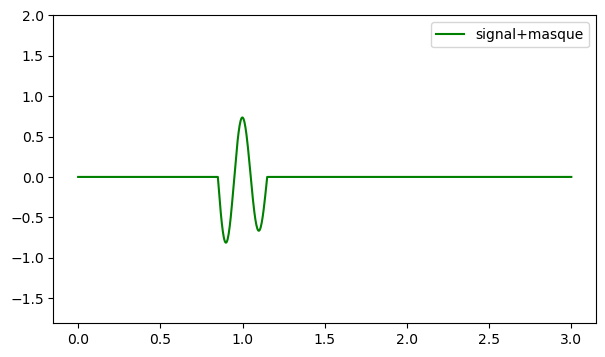

In [6]:
plt.figure(figsize = (7,4))

plt.plot(t, porte_0*signal, label="signal+masque", color ="green")

plt.ylim( signal.min(), signal.max())
plt.legend()
plt.show()

<h2> On peut donc observer le signal tout entier en déplaçant progressivement la position du masque ( son centre ) sur tout le domaine du signal de façon à avoir une photographie de signal sur chaque instant

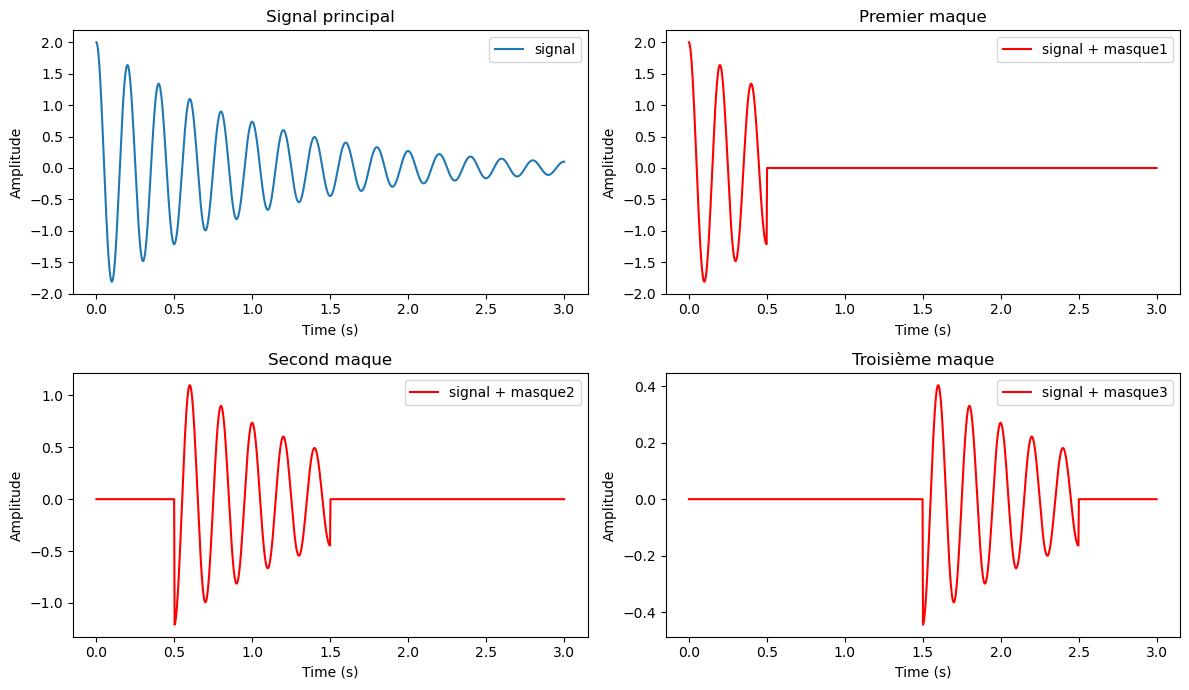

In [12]:
fig , ax = plt.subplots(2,2, figsize = (12,7))

ax[0,0].plot(t , signal , label = "signal")
ax[0,0].title.set_text("Signal principal")
ax[0,0].set_xlabel("Time (s)")
ax[0,0].set_ylabel("Amplitude")
ax[0,0].legend()

ax[0,1].plot(t , signal*porte(0 , durée/3) , label = "signal + masque1", color="red")
ax[0,1].title.set_text("Premier maque")
ax[0,1].set_xlabel("Time (s)")
ax[0,1].set_ylabel("Amplitude")
ax[0,1].legend()

ax[1,0].plot(t , signal*porte(1 , durée/3) , label = "signal + masque2", color="red")
ax[1,0].title.set_text("Second maque")
ax[1,0].set_xlabel("Time (s)")
ax[1,0].set_ylabel("Amplitude")
ax[1,0].legend()

ax[1,1].plot(t , signal*porte(2 , durée/3) , label = "signal + masque3", color="red")
ax[1,1].title.set_text("Troisième maque")
ax[1,1].set_xlabel("Time (s)")
ax[1,1].set_ylabel("Amplitude")
ax[1,1].legend()

plt.tight_layout()
plt.show()

In [8]:
class Fourrier_Transform(  ):
    N_instances = 0

    def __init__( self, frequences = None, function = None , sampling_rate = None , maximum_frequence = None ) :
        """
        DESCRIPTION : 
        ------------
            Constructeur de la classe qui defini et construit les variables pertinentes
        
        PARAMETRES : 
        -----------
            - Frequences : String or Numpy Array
                Variable contenant les fréquences. Pour utiliser un seul signal harmonique de fréquence 200 Hz, la variable peut prendre la valeur "200".
                Si par contre on désire supperposer deux signaux harmoniques de fréquences 100 et 200 Hz elle prends la valeur "100 200"; l'espace laissé entre les
                deux valeurs signfie qu'il y a addition des signaux. Si par contre il faut multiplier les signaux alors donner la valeur "100*200" et plus 
                généralement s'il faut utiliser un signal résultat de l'addition d'une multiplication de signaux il faut envoyer les valeurs
                sous la forme "100*60 300"; ce qui signifie que le signal résulte de la multiplication de deux signaux harmoniques de fréquence 100 et 60 Hz puis
                additionné à un signal de fréquence 300 Hz.
                    
            - function: func, str, np.array
                Lambda fonction à employer comme noyau à la fonction périodique si on ne voudrait pas utiliser de fonction harmonique. laisser la valeur par defaut `None`
                dans le cas contraire. En combinant diverses valeurs des variables `frequences` et `function` il est possible de construire différents types de signaux 
                périodiques. On peut lui attribuer les valeurs "carré", "triangle", "neg_exp" et "pos_exp" pour les fonctions associées carré, dent de scie et expo.
            
            - sampling_rate : int
                Sample Rate associé à la fonction temporelle si la fonction est directement fournie sous forme d'arrays de données discrètes
                    
        OUTPUT :  None
        ------- 
        
        AUTHOR : 
        --------
            BRICE KENGNI ZANGUIM
            kenzabri2@yahoo.com
        
        """
        ####################################################################################
        #####################         Fonctions et sampling rate         ###################
        ####################################################################################
        self.function = function
        
        if isinstance( self.function, ( list, type( np.array( [ 10 , 0 ] ) ) ) )  :
            try :
                self.sr = sampling_rate
            except :
                print("Veillez fourinir la valeur de la variable 'sampling_rate'")
                
            self.signal = self.function
            
            self.N = self.signal.size
            
            self.duration = self.N/self.sr
            
            self.t = np.linspace( 0 , self.duration, self.N )
            
            self.t_step = self.t[1]
            
            self.f_0  = np.fft.fftfreq( self.N, self.t_step )
            
            if maximum_frequence is not None :
                self.F_max = maximum_frequence
            else :
                self.F_max = self.sr/10
            
            
            
        else :
            ####################################################################################
            #####################     Fréquences et périodes des signaux     ###################
            ####################################################################################
            if frequences : 
                if isinstance( frequences, str) :
                    Fs = self.remove_blank_space(frequences).split(" ")
                    for i in range( len( Fs ) ) :
                        Fs.insert( i , np.array([ float(j) for j in Fs[i].split("*") ]) )
                        del Fs[i+1]
                    Fs = np.array(Fs , dtype=object)

            self.Fs = Fs

            self.Ts = map( lambda x : 1./x ,  self.Fs  )
            self.Ts = self.from_map_to_array( self.Ts )

            ####################################################################################
            ###############    Fréquence maximale dans l'espace des fréquence     ##############
            ####################################################################################
            if maximum_frequence is not None :
                self.F_max = maximum_frequence
            else :
                self.F_max = max( 15*self.minim(self.Fs), self.maxim(self.Fs) + 5*self.minim(self.Fs) )*np.sqrt(Fs.size)

            ####################################################################################
            #########################  Plus petit intervall de temps    ########################
            ####################################################################################
            self.t_step = 0.001*self.minim(self.Ts)

            ####################################################################################
            #######################       Durée du signal        ###############################
            ####################################################################################
            self.duration = 8*self.maxim(self.Ts)

            ####################################################################################
            ################   Nombre d'échantillons en temps; discrétisation   ################
            ####################################################################################
            self.N = int(self.duration/self.t_step)

            ####################################################################################
            #### Étendue temporelle du signal : échantillon du temps sur toute sa durée   ######
            ####################################################################################
            self.t = np.linspace( 0 , self.duration , self.N )

            ####################################################################################
            ###################         Échantillonage en fréquence          ###################
            ####################################################################################
            self.f_0  = np.fft.fftfreq(self.N, self.t[1])

        ####################################################################################
        ##################        Incrément du nombre d'instances         ##################
        ####################################################################################
        self.N_instances += 1
        
    def transform( self, ) :
        """
        DESCRIPTION : 
        ------------
            Applique une transformée de Fourrier
        
        OUTPUT :  tupple
        ------- 
            Renvois un tupple de 2 listes représentante respectivement les modules | FFT | et les argument Arg(FFT) de la transformée de Fourrier pour une fréquence donnée
            
        AUTHOR : 
        --------
            BRICE KENGNI ZANGUIM
            kenzabri2@yahoo.com
        
        """
        ###########################################################################
        ######################     Signal à transformer      ######################
        ###########################################################################
        
        if self.function is not None :
            if isinstance( self.function, ( list, type( np.array( [ 10 , 0 ] ) ) ) ) :
                pass

            else :
                self.signal = 0.
                if self.function == "carré" :
                    for i in self.Fs :
                        prod = 1.
                        for j in i :
                            prod *=  self.t%(1./j) > 1/(2.*j)

                        self.signal += prod

                elif self.function == "triangle" :
                    for i in self.Fs :
                        prod = 1.
                        for j in i :
                            prod *= self.t%(1./j)

                        self.signal += prod

                elif self.function =="neg_exp" :
                    for i in self.Fs :
                        prod = 1.
                        for j in i :
                            prod *= np.exp( -3.*j*(self.t%(1./j)) )

                        self.signal += prod

                elif self.function == "pos_exp" :
                    for i in self.Fs :
                        prod = 1.
                        for j in i :
                            prod *= np.exp( 3.*j*(self.t%(1./j)) )

                        self.signal += prod

                else :
                    for i in self.Fs :
                        prod = 1.
                        for j in i :
                            prod *= self.function( 3*j*(self.t%(1./j)) )

                        self.signal += prod
                        
        else:
            self.signal = 0.
            for i in self.Fs :
                prod = 1.
                for j in i :
                    prod *= np.sin(2*np.pi*j*self.t)

                self.signal += prod
                
        ###########################################################################
        ######################     Transformée du signal     ######################
        ###########################################################################
        self.FFT_0 = np.fft.fft(self.signal)

        ###########################################################################
        ####### Réduction du résultat en dessous d'une fréquence maximale  ########
        ###########################################################################
        filtre = np.abs(self.f_0) <= self.F_max
        FFT = self.FFT_0[filtre]
        self.f = self.f_0[filtre]

        ###########################################################################
        ######################       Module et argument      ######################
        ###########################################################################
        FFT_mag = np.abs(FFT) #np.real(FFT*np.conjugate(FFT)/FFT.size) #np.abs(FFT)
        FFT_arg = np.angle(FFT, deg=True)

        ###########################################################################
        ###################   Suppression des fréquences négatives  ###############
        ###########################################################################
        self.N = self.f.size
        self.f_pos = self.f[1:self.N//2]
        self.FFT_mag_pos = FFT_mag[1:self.N//2]
        self.FFT_arg_pos = FFT_arg[1:self.N//2]
        
        return self.FFT_mag_pos, self.FFT_arg_pos
        
    def plot( self, style= "SMA" , title = "", figsize = (10,8) , freq_min = 0, freq_max = None ) :
        """
        DESCRIPTION : 
        ------------
            Affiche respectivement le signal, le spectre  d'Amplitude et le spectre de Phase
            
        PARAMETRES :
        -----------
            - style: str
                Chaine de caractères qui indique le type de graphe à afficher. La chaine de caractère peut contenir essentiellemetn les lettres 'S':Signal ,'M':Module et 
                'A': Argument. En fonction de la chaine de caractère qui est affichée, le graph affichera simultanément ou l'un des trois graphes correspondant au signal,
                au module et à l'argument.
            - freq_min, freq_max : float
                
        
        OUTPUT : None
        ------- 
            
        AUTHOR : 
        --------
            BRICE KENGNI ZANGUIM
            kenzabri2@yahoo.com
        
        """
        while len(style) > 3 :
            style = input(f"La variable 'style' ne doit contenir que 3 caractère au maximum. La valeur actuelle est : {style}\n Veillez entrer une nouvelle valeur")
        
        fig, ax = plt.subplots(nrows= len(style), ncols=1, figsize= figsize)
        fig.suptitle(title, size = figsize[0]*2)
        style = list(style.upper())
        style.sort(reverse=True)
        style = "".join(style)
        
        for i in range(len(ax)) :
            ###########################################################################
            ###################           Affichage du signal           ###############
            ###########################################################################
            if "S" in style :
                ax[style.find("S")].plot(self.t, self.signal, color= 'blue', )
                ax[style.find("S")].set_xlabel("Temps ( sec )")
                ax[style.find("S")].set_ylabel("Amplitude")
                ax[style.find("S")].title.set_text("Evolution du signal")

            ###########################################################################
            ###################     Affichage du spectre en fréquence   ###############
            ###########################################################################
            if "M" in style :
                ax[style.find("M")].plot(self.f_pos, self.FFT_mag_pos, color="green")
                ax[style.find("M")].set_xlabel("Freq ( Hz )")
                ax[style.find("M")].set_ylabel("| FFT |")
                ax[style.find("M")].title.set_text("Spectre d'Amplitude du signal")
                if freq_max is not None :
                    ax[style.find("M")].set_xlim( freq_min,freq_max )

            ###########################################################################
            ###################      Affichage du spectre de phase      ###############
            ###########################################################################
            if "A" in style :
                ax[style.find("A")].plot(self.f_pos, self.FFT_arg_pos, color="magenta")
                ax[style.find("A")].set_xlabel("Freq ( Hz )")
                ax[style.find("A")].set_ylabel("Phase ( deg )")
                ax[style.find("A")].title.set_text("Spectre d'Argument du signal")
                if freq_max is not None :
                    ax[style.find("A")].set_xlim(freq_min,freq_max)

        plt.tight_layout()
        
        plt.show()
    
    def minim(self, x) :
        """
        DESCRIPTION : 
        ------------
            Calcul le minimum de toutes les valeurs contenues dans une ittérable obtenu par la fonction map()
            
        PARAMETRES :
        -----------
            - x : itterable
        
        OUTPUT : int, float
        ------- 
            
        AUTHOR : 
        --------
            BRICE KENGNI ZANGUIM
            kenzabri2@yahoo.com
        
        """
        
        return min([min(i) for i in x])

    def maxim(self, x) :
        """
        DESCRIPTION : 
        ------------
            Calcul le maximum de toutes les valeurs contenues dans une ittérable obtenu par la fonction map()
            
        PARAMETRES :
        -----------
            - x : itterable
        
        OUTPUT : int, float
        ------- 
            
        AUTHOR : 
        --------
            BRICE KENGNI ZANGUIM
            kenzabri2@yahoo.com
        
        """
        
        return max([max(i) for i in x])
    
    def from_map_to_array( self , x ) :
        """
        DESCRIPTION : 
        ------------
            Converti une variable itterable obtenu par la fonction map() en une variable de type numpy array
            
        PARAMETRES :
        -----------
            - x : itterable
        
        OUTPUT : np.array
        ------- 
            
        AUTHOR : 
        --------
            BRICE KENGNI ZANGUIM
            kenzabri2@yahoo.com
        
        """
        
        return np.array([ np.array(i) for i in x ], dtype=object)
    
    def remove_blank_space(self, x) :
        """
        DESCRIPTION : 
        ------------
            Rétire les espaces vides qui se trouvent en début ou à la fin d'une chaine de caractère
            
        PARAMETRES :
        -----------
            - x : str
        
        OUTPUT : str
        ------- 
            
        AUTHOR : 
        --------
            BRICE KENGNI ZANGUIM
            kenzabri2@yahoo.com
        
        """
        
        if x[-1] == " " :
            while x[-1] == " " :
                x = x[:-1]
                
        if x[0] == " " :
            while x[0] == " " :
                x = x[1:]
        
        return x
    
    def pic_spectral( self,  f_min , f_max ) :
        """
        DESCRIPTION : 
        ------------
            Recherche la fréquences correspondant à un maximum d'amplitude spectral dans une bande de fréquence donnée du spectre d'amplitude du signal
            
        PARAMETRES :
        -----------
            - f_min , f_max : float
                borne inférieur et supperieur de la bande de fréquence où doit être recherché le maximum. La bande de fréquence est alors definie comme [f_min, f_max]
        
        OUTPUT : ( float, float )
        ------- 
            Fréquence et Amplitude  du spectre correspondant à un maximum de fréquence et d'amplitude dans la bande de fréquence précisée
            
        AUTHOR : 
        --------
            BRICE KENGNI ZANGUIM
            kenzabri2@yahoo.com
        
        """
        filtre = (self.f_pos >= f_min) * (self.f_pos <= f_max)
        freq = self.f_pos[filtre]
        mag = self.FFT_mag_pos[filtre]
        
        return freq[mag.argmax()], mag.max()
    
    def pics_spectraux( self,  Amp_min, inter = 100 , repetition = 10, methode = 1) :
        """
        DESCRIPTION : 
        ------------
            Recherche la fréquences correspondant à un maximum d'amplitude spectral dans une bande de fréquence donnée du spectre d'amplitude du signal
            
        PARAMETRES :
        -----------
            - Amp_min : float
                Valeur minimale de l'amplitude d'une amplitude pour être considéré comme un pic. PAr exemple une valeur de 100 signifie que toutes les amplitudes suppéreiures
                à 100 sont considérés comme des pics; la méthode ici est repose plus sur l'aspect visuel du spectre.
            - inter : float
                Plus petit intervall de fréquence qui doit exister entre 2 pics de fréquences observés
            - repetition : int
            
            - methode : int
        
        OUTPUT : DataFrame
        ------- 
            DataFrame des Fréquences et Amplitude  du spectre correspondant à un maximum d'amplitude
            
        AUTHOR : 
        --------
            BRICE KENGNI ZANGUIM
            kenzabri2@yahoo.com
        
        """
        if methode == 1 :
            ###############################################################################################
            #####   Sélection des fréquences et amplitudes suppérieurs à la limite minimale envoyée   #####
            ###############################################################################################
            filtre = self.FFT_mag_pos >= Amp_min
            freq = self.f_pos[ filtre ]
            mag = self.FFT_mag_pos[ filtre ]

            #######################################################################################################################################
            ##########    Filtrage des fréquences  et amplitudes avec plusieurs repetittions pour plus de robustesse de la recherche     ##########
            #######################################################################################################################################
            new_freq  = [ ]
            a = [inter]
            for i in range(repetition) :
                f_min = 0
                f_max = f_min + inter*np.power(13/23, i)
                
                var = []
                while np.any( f_min < freq ) :
                    filtre_0 = ( freq >= f_min)*(freq < f_max )
                    if np.any( filtre_0 ) :
                        idx  = mag[ filtre_0 ].argmax( )
                        var.append(freq[ filtre_0 ][ idx ])
                        new_freq.extend( [ freq[ filtre_0 ][ idx ] ] )
                        
                    a.extend( np.array( var[1:] ) - np.array(var[:-1]) )
                    
                    if len(a) > 1 :
                        inter  =  np.mean( [np.min(a), np.max(a), np.mean(a), np.median(a), np.quantile(a,.7), np.quantile(a,.4), np.quantile(a,.6), np.quantile(a,.8)] )*np.power(22/23, i)
                    else :
                        inter -= 10
                    
                    #print(f"{inter}    {np.mean(a)}    {np.median(a)}    {np.min(a)}    {np.max(a)}    {np.std(a)}")

                    f_min = f_max
                    f_max += inter

            ###############################################################################################
            #####   Affinement de la recherche de frequences par intersection des ensembles obtenus   #####
            ####  Par déduction sélection des amplitudes finales correspondant aux fréquences finales  ####
            ###############################################################################################
            #final_freq = set(new_freq[-1])
            #for i in range(repetition-1): 
            #    final_freq.intersection_update( new_freq[i] )
            #final_freq = list(final_freq)
            final_freq, final_mag = [] , []
            uniq_freq, count = np.unique(new_freq, return_counts=True)
            for i in range(uniq_freq.size) :
                if count[i] > repetition*0.9 :
                    final_freq.append( uniq_freq[i] )
                    final_mag.append( mag[freq == uniq_freq[i] ] )
            
            ###############################################################################################
            ############    Réarrangement des résultat dans l'ordre croissant des fréquences   ############
            ###############################################################################################
            final_freq = np.array(final_freq).ravel()
            final_mag = np.array(final_mag).ravel()
            idx =  final_freq.argsort()
            final_mag = final_mag[idx]
            final_freq = final_freq[idx]
        elif methode == 2 :
            pass
        
        return pd.DataFrame({"Fréquences": final_freq, "Amplitude": final_mag})
    
    def invers_transform( self , seuil = -1, methode= 1 , max_pics = None) :
        """
        DESCRIPTION : 
        ------------
            Calcul les coefficients de la transformée de Fourier inverse
        
        PARAMETRES :
        -----------
            - seuil : float
                seuil d'amplitude en dessous duquel les fréquences sont supposées avoir une amplitude nulle. Ce seuil est necessaire lorsqu'il faut débruiter le signal. Il
                permet en effet d'établir une limite sur l'amplitude des fréquences : les fréquences ayant une amplitude plus grande sont conservés dans la somme tandis que 
                ceux ayant une amplitude inférieur à ce seuil sont simplement retiré de la sommation ( amplitude = 0 ).
                Pour réaliser une transformée de Fourier inverse sans necessairement débruiter le signal il suffit de donner une valeur négative; d'ailleurs la valeur par
                defaut de cette variable est égale à -1
        
        OUTPUT : Array
        ------- 
            coefficients de la transformée inverse
            
        AUTHOR : 
        --------
            BRICE KENGNI ZANGUIM
            kenzabri2@yahoo.com
        
        """
        if max_pics is not None :
            q = 1. - max_pics/self.FFT_mag_pos.size
            seuil = np.quantile( self.FFT_mag_pos , q )
        
        if methode == 1 :
            self.PSD = np.abs(self.FFT_0) #self.FFT_0*np.conjugate(self.FFT_0)/self.N       # Power spectral Density
            filtre = self.PSD >= seuil
            self.PSD_filtre_bruit = self.PSD*filtre
            self.FFT_0_filtre_bruit = self.FFT_0*filtre
            self.IFFT = np.fft.ifft( self.FFT_0_filtre_bruit )
            self.IFFT = np.real(self.IFFT )
        elif methode == 2 :
            pass
        
        return self.IFFT

- ## <strong> Discussion  </strong>

<h3>
<ol>
    <li> La fondamentale de la C4 au saxophone se situe à 261 Hz bien que son amplitude soit inférieur à la seconde harmonique  </li>
    <li> Pour la note C4 au Saxophone, en plus des harmoniques observées au piano il apparait aussi des harmoniques intermédiaires sensiblement à mis chemin des autres harmoniques observées ; </li>
    <li> La note C4 est beaucoup plus riche en fréquence au saxophone qu'au piano </li>
</ol>
</h3>

---

- ## <strong> Authors </strong>

 #### <ul> <p> - <strong><a href="https://www.linkedin.com/in/brice-kengni-zanguim/" target="_blank">Brice KENGNI ZANGUIM :</a> </strong></p> <ul> Artificial Intelligence Engeneer at home and holds a PhD in Nano-physic. His research focused on using <strong>Machine Learning, Deep Learning, Signal Processing, Natural langage Processing, Computer Vision and so one</strong> to figure out how the world behave and impact human cognition. Brice KENGNI ZANGUIM has been working at home on mastering his own AI projects in many domains while seeking for a position in a company. </ul></ul>


---

- ## <strong> Other Contributors </strong>

#### <ul>None</ul>

---

- ## <strong> Change Log </strong>

|  Date (DD-MM-YYYY) |  Version | Changed By  |  Change Description |  Purpose  |
|---|---|---|---|---|
| 16- 03 - 2023 | 1.0 | Brice KENGNI ZANGUIM | Updated the file | Mem,save |
|-|-|-|-|
|   |   |   |   |   |

### <h3 align="center"> © BKZ Corporation 2023. All rights reserved. <h3/>
---